## **Mount Drive (When Using Google Colab)**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/NeuriteOutgrowth

Mounted at /content/gdrive
/content/gdrive/My Drive/NeuriteOutgrowth


# **Process Full Experiment Data**

**Processing experiment data using this repository consists of two stages:**
1. Process every pair of images in the experiment (FITC & DAPI) using the computer vision pipeline that detects the neurites, cells etc. and extracts raw data from the images.
2. Process the data (from phase 1) of each well in the experiment. Data processing pipeline includes outlier removal and complex features calculations. The output of this part could easily be used to calculate statistics for each well to detect "hits" (compounds that have a statistically significant impact on the cell culture's neurite outgrowth measures).

**To demostrate running an experiment, we will use experiment data found in the following link:**
[https://drive.google.com/drive/folders/1732_SIn6r3x8eU7y-2Pf_LIr0sE4OQQQ?usp=sharing](https://drive.google.com/drive/folders/1732_SIn6r3x8eU7y-2Pf_LIr0sE4OQQQ?usp=sharing)

**Notice:  The code in the repository assumes similar naming to the images in the folder the above link leads to (mind the spacing) for example:**



*   The name of the DAPI image of field number 1 in row B and column 11 would be:

 "B - 11(fld 01 wv DAPI - DAPI).tif"
*   Similarly the name of the FITC image in field number 10 in row C and column 03 would be: 

  "C - 03(fld 10 wv FITC - FITC).tif" 







**Dont forget (!!!) to download the [Mask RCNN weights](https://drive.google.com/file/d/1sX5u0dEBvA8Y8z8UObXsty-CE_TjWNKH/view?usp=sharing) and place them in the repository root directory  ("NeuriteOutgrowth" folder)**

**Set NeuriteOutgrowth as root directory**

In [ ]:
import os
import sys
import subprocess

# Set NeuriteOutgrowth folder as root directory of the project
current_dir = os.getcwd()
last_folder_in_dir = os.path.basename(os.path.normpath(current_dir))
assert last_folder_in_dir == "NeuriteOutgrowth", "you need to set NeuriteOutgrowth as root dir"
ROOT_DIR = current_dir

# Import repo
sys.path.append(ROOT_DIR)  # To find local version of the library

**Indicate the position of the two h5 files (models and weights) download Mask RCNN weights if needed**

In [ ]:
# Local path to trained model h5 file (assuming they were saved on root directory)
neurite_segmentation_model_path = os.path.join(ROOT_DIR, "neurite_unet_weights.h5")
assert os.path.exists(neurite_segmentation_model_path), "please download neurite_unet_weights.h5 file into ROOT_DIR"

# Local path to trained weights h5 file (assuming they were saved on root directory)
mask_rcnn_weights_path = os.path.join(ROOT_DIR, "deepretina_final.h5")
assert os.path.exists(mask_rcnn_weights_path), "please download deepretina_final.h5 file (Mask RCNN weights)  into ROOT_DIR"

## **Modifications for Google Colab only**

This section will install packages not in Google Colab and select Tensorflow 1.

You might be asked to restart runtime

**Downgrade h5py**

In [ ]:
pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 13.8 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


**install "skan"**

In [ ]:
pip install skan

     |████████████████████████████████| 1.5 MB 11.1 MB/s 
     |████████████████████████████████| 47 kB 4.9 MB/s 


**Use Tensorflow 1 and restart (no need to run cell again after restarting)**

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## **Set Configurations**
Please set the configurations before running the experiment as this is crucial for getting the right results. For more information about the parameters of the configuration read the code and comments of class ExperimentConfig in experiment_config.py and the thesis.

**Example Configurations:**

The example data consists of 7 wells, each well was imaged using 5 different fields of view (each field consists of a DAPI image and a FITC image). Therefore we will change the FIELDS_PER_WELL constant to 5, and the MIN_VALID_FIELDS and RANSAC_MIN_SAMPLES to 2 (or any other number smaller or equal to 5). 

In [ ]:
from src.experiment_config import ExperimentConfig
class ExampleConfig(ExperimentConfig):
    # number of fields of view in each well - pairs of images (DAPI and FITC) for each field
    FIELDS_PER_WELL = 5
    # minimum number of fields to accept the results of a well as valid
    MIN_VALID_FIELDS = 2

    # unsupervised outlier removal constants:
    # straight line will be calculated using Random Sample Consensus (RANSAC) algorithm
    # with number of samples randomly selected equal to RANSAC_MIN_SAMPLES.
    RANSAC_MIN_SAMPLES = 2



exp_config = ExampleConfig()
exp_config.display()


Configurations:
BIN_SIZE                       25
DISK_MASK                      [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
D_EPS                          100
EPS                            0
FIELDS_PER_WELL                5
MAX_APOP_RATIO                 0.25
MAX_CELL_NUM                   1000
MAX_DISTANCE                   1000
MAX_HIGH_DENSITY_RATIO         0.45
MIN_CELL_NUM                   50
MIN_DISTANCE                   0
MIN_SAMPLES                    10
MIN_VALID_FIELDS               2
NEURITE_SEGMENTATION_MODEL_PATH Old_Architechture_neurite_net_cosine.h5
NUCLEI_MASK_RCNN_WEIGHTS_PATH  deepretina_final.h5
PROBABILITY_THRESHOLD          0.05
RADIUS                         15
RANSAC_MIN_SAMPLES             2




## **1. Run Computer Vision Pipeline - Use GPU**

The CV pipeline extracts raw features related to neurite outgrowth from the input images.

Users should mention The input images folder, the results output folder (should be an empty folder) and the experimental configurations.

**Note:** Its possible to run an experiment in multiple runs if runtime is very long. To do that just run the cell again with the same input and output folder - the if an output file exists the algorithm knows to identify the last saved well and continue to the next one.




**Disable Deprecation Warnings**

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

TensorFlow 1.x selected.


**Extract neurite outgrowth related data from all the images**

In [ ]:
from src.computer_vision_pipeline.experiment_inference_utils import extract_data_from_plate_images
import os


Mydrive_full_path = r'/content/gdrive/MyDrive'
input_images_folder = os.path.join(Mydrive_full_path,'Example_Experiment')
results_output_folder = os.path.join(Mydrive_full_path, 'CV_Pipeline_Results')
extract_data_from_plate_images(input_images_folder, results_output_folder, exp_config)

Using TensorFlow backend.
wells processed: 100%|██████████| 7/7 [23:49<00:00, 204.19s/wells]


## **2. Run data Processing**

This part takes as input the raw data that was extracted in the CV pipeline and performs outlier removal (removes fields with extreme values) and calcultes complex features. For more information regarding the outlier removal or feature calculation please refer to the thesis.

**Notice:** it is necessary to declare the negative reference wells as they are used as reference to calculate the complex features.

In [ ]:
from src.data_processing.processing_experiment_data import process_plate_data
import os
negative_ref_wells = ["F - 10"]
Mydrive_full_path = r'/content/gdrive/MyDrive'
results_output_folder = os.path.join(Mydrive_full_path, 'CV_Pipeline_Results')

plate_processed_data = process_plate_data(results_output_folder, negative_ref_wells, exp_config)

**The output of the second stage is a dictionary that contains a dictionary for each well's results:**

a. Numerical results for the different attributes.

b. A dictionary that holds outlier and toxicity information.

In [ ]:
plate_processed_data['B - 02']

{'# Cells': 2852,
 'Disconnected With Neurites': 1.8606861607479939,
 'Expected VS Real Connection Ratio': 1.7975237028037558,
 'Intermediate Connection Probability': 0.0817431665807117,
 'Long Connection Probability': 0.0145526455898385,
 'Neurite Average': 155.69973702664797,
 'Normalized Neurite Length': 147.71000687415886,
 'Short Connection Probability': 0.2613033594342006,
 'Valid Fields': 5,
 'Very Long Connection Probability': 0.0012205001322505003,
 'outlier_dictionary': {'Apoptosis Ratio After Outlier Removal': 0.06,
  'Apoptosis Ratio Before Outlier Removal': 0.06,
  'Number of Fields With Apoptosis': 0,
  'Number of Fields With Clustered Cells': 0,
  'Number of Fields With High Cell Count': 0,
  'Number of Fields With Low Cell Count': 0,
  'Number of Unsupervised Outlier Fields': 0,
  'Valid Fields': 5}}

## **Results Visualizations**

**In this section we will provide an example of visualizing an experiment's results:**

Let us consider the example experiment: Well "F - 10" is the negative reference well and the rest of the wells are the test wells.  


**Looking for Spatial Bias** 

Visualizing the experiment's plate may allow for detecting experimental biases. for example high levels of toxicity in certein parts of the plate or lower number of cells in the plate edges. 

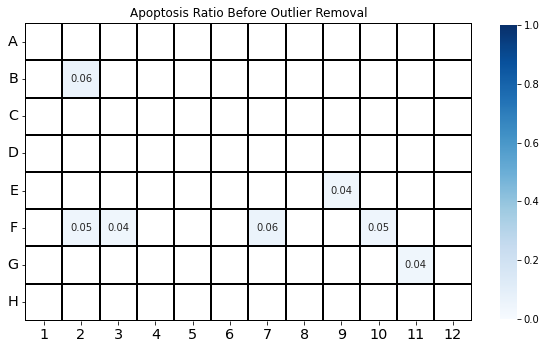

In [ ]:
from src.data_processing.results_visualization import visualize_plate
visualize_plate(plate_processed_data, feature='Apoptosis Ratio Before Outlier Removal', outlier=True, max_value=1)

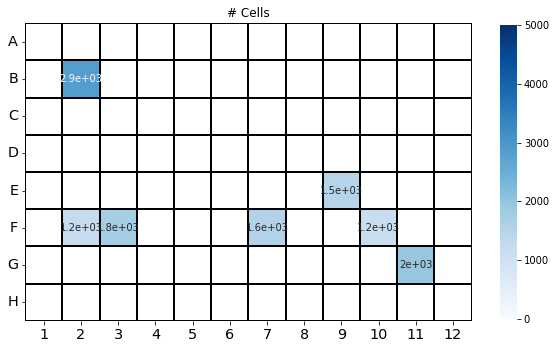

In [ ]:
visualize_plate(plate_processed_data, feature='# Cells', outlier=False, max_value=5000)

**Hit Detection**

In order to visually detect wells that have statistically significant neurite outgrowth value we can for instance plot all the well's z-score values for a specific feature.

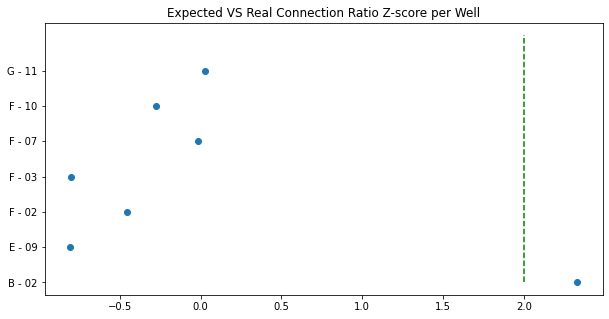

In [ ]:
from src.data_processing.results_visualization import visualize_hits
visualize_hits(plate_processed_data, feature='Expected VS Real Connection Ratio', figsize=(10,5), k=2)

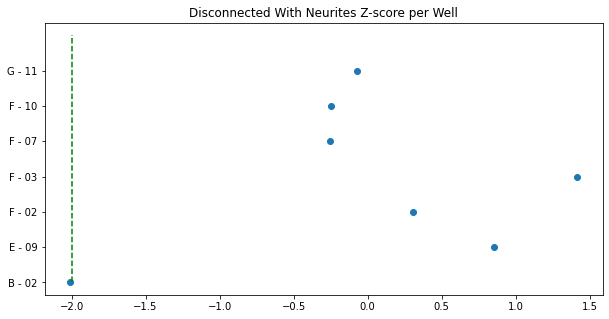

In [ ]:
visualize_hits(plate_processed_data, feature='Disconnected With Neurites', figsize=(10,5), k=-2)